<a href="https://colab.research.google.com/github/derekphilipau/glazy-data/blob/master/glazy_predict_cone_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This Notebook was adapted from the excellent tutorial [Basic regression: Predict fuel efficiency](https://www.tensorflow.org/tutorials/keras/regression), video: [Get started with using TensorFlow to solve for regression problems](https://www.youtube.com/watch?v=-vHQub0NXI4)

# Basic regression: Predict Glaze Firing Cone (Temperature)

In a *regression* problem, the aim is to predict the output of a continuous value, like a price or a probability. Contrast this with a *classification* problem, where the aim is to select a class from a list of classes (for example, where a picture contains an apple or an orange, recognizing which fruit is in the picture).

This notebook uses data from the [Glazy Data Project](https://github.com/derekphilipau/glazy-data/) and builds a model to predict the firing temperature (Orton cone) of a glaze.  To do this, we look at the oxides of chemical analyses of glazes, like SiO2, Al2O3, CaO, etc.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

Please see [Pieter Mostert's](https://github.com/PieterMostert) earlier work, [Glazy Data Analysis](https://github.com/PieterMostert/glazy-data-analysis) which goes deeper into problems with the Glazy dataset and discusses ways to deal with this problem.

In [1]:
# Use seaborn for pairplot
!pip install -q seaborn

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [3]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

print(tf.__version__)

2.4.1


### Get the data
First download and import the dataset using pandas.  Only perform this step with ONE of the following cells:
* FULL OXIDES:  Include all major oxides.  Round to hundredths of a percent.  Mol%
* FULL OXIDES WITHOUT SPECIALTY GLAZES: Include major oxides,  Do NOT include specialty glazes.  Round to tenths of a percent.  Mol%.  START WITH THIS DATASET.
* LIMITED OXIDES: Include only a subset of oxides.  Round to hundredths of a percent.  Mol%
* LIMITED OXIDES: Include only a subset of oxides.  Does NOT include specialty glazes.  Round to hundredths of a percent.  Mol%
* LIMITED UMF OXIDES: Include a very limited subset of oxides in UMF.  Round to hundredths of a percent.  

NOTES:
* All files have been purged of duplicate rows (based on chemical analyses)
* Cones are Glazy ID's for cones, not actual cone numbers (e.g. "010").  Cone 6 = 30, Cone 10 = 34.

FULL OXIDES:

In [ ]:
url = 'https://github.com/derekphilipau/glazy-data/raw/master/machine-learning/data/20210409_glazes_unique_regression.csv'
column_names = ['cone', 'SiO2', 'Al2O3', 'B2O3', 'Li2O', 'K2O', 'Na2O', 'KNaO', 'MgO', 'CaO', 'SrO', 'BaO', 'ZnO', 'PbO', 'P2O5', 'Cr2O3', 'MnO', 'MnO2', 'FeO', 'Fe2O3', 'CoO', 'NiO', 'CuO', 'Cu2O', 'TiO2', 'ZrO2', 'SnO2']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

OR FULL OXIDES WITHOUT SPECIALTY GLAZES (Using this dataset for now.)

In [129]:
url = 'https://github.com/derekphilipau/glazy-data/raw/master/machine-learning/data/20210409_glazes_unique_regression_no_specialty.csv'
column_names = ['cone', 'SiO2', 'Al2O3', 'B2O3', 'Li2O', 'K2O', 'Na2O', 'MgO', 'CaO', 'SrO', 'BaO', 'ZnO', 'PbO', 'P2O5', 'Cr2O3', 'MnO', 'MnO2', 'FeO', 'Fe2O3', 'CoO', 'NiO', 'CuO', 'Cu2O', 'TiO2', 'ZrO2', 'SnO2']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

OR LIMITED OXIDES:

In [4]:
url = 'https://github.com/derekphilipau/glazy-data/raw/master/machine-learning/data/20210409_glazes_unique_regression_limited.csv'
column_names = ['cone','SiO2','Al2O3','B2O3','Li2O','KNaO','MgO','CaO','SrO','BaO','ZnO','P2O5','MnO2','Fe2O3','TiO2']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

OR LIMITED OXIDES WITHOUT SPECIALTY GLAZES:

In [62]:
url = 'https://github.com/derekphilipau/glazy-data/raw/master/machine-learning/data/20210409_glazes_unique_regression_limited_no_specialty.csv'
column_names = ['cone','SiO2','Al2O3','B2O3','Li2O','KNaO','MgO','CaO','SrO','BaO','ZnO','P2O5','MnO2','Fe2O3','TiO2']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

OR LIMITED UMF OXIDES:

In [ ]:
url = 'https://github.com/derekphilipau/glazy-data/raw/master/machine-learning/data/20210409_glazes_unique_regression_limited_umf.csv'
column_names = ['cone', 'SiO2', 'Al2O3', 'B2O3', 'R2O', 'RO']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=',', skipinitialspace=True)

In [130]:
dataset = raw_dataset.copy()
dataset.tail()

,cone,SiO2,Al2O3,B2O3,Li2O,K2O,Na2O,MgO,CaO,SrO,BaO,ZnO,PbO,P2O5,Cr2O3,MnO,MnO2,FeO,Fe2O3,CoO,NiO,CuO,Cu2O,TiO2,ZrO2,SnO2
10235,8.0,50.5,8.0,14.6,7.8,1.7,8.0,1.8,7.2,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10236,8.0,51.1,7.5,14.4,8.8,1.8,7.0,0.1,9.0,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10237,9.0,29.0,3.0,5.0,0.0,0.0,10.4,0.0,5.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10238,9.0,53.5,7.2,12.3,9.2,3.5,7.7,0.0,6.3,0.0,0.0,0.4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
10239,9.0,53.9,3.5,13.3,9.5,1.7,10.1,0.0,6.7,0.0,0.0,0.3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.4


### Clean the data

See if the dataset contains unknown values.

In [131]:
dataset.isna().sum()

cone     0
SiO2     1
Al2O3    1
B2O3     1
Li2O     1
K2O      1
Na2O     1
MgO      1
CaO      1
SrO      1
BaO      1
ZnO      1
PbO      1
P2O5     1
Cr2O3    1
MnO      1
MnO2     1
FeO      1
Fe2O3    1
CoO      1
NiO      1
CuO      1
Cu2O     1
TiO2     1
ZrO2     1
SnO2     1
dtype: int64

Drop rows with unknown values.

In [132]:
dataset = dataset.dropna()

### Split the data into train and test

Now split the dataset into a training set and a test set.

Use the test set in the final evaluation of our models.

In [133]:
train_dataset = dataset.sample(frac=0.8, random_state=0)
test_dataset = dataset.drop(train_dataset.index)

In [134]:
train_dataset.head()

,cone,SiO2,Al2O3,B2O3,Li2O,K2O,Na2O,MgO,CaO,SrO,BaO,ZnO,PbO,P2O5,Cr2O3,MnO,MnO2,FeO,Fe2O3,CoO,NiO,CuO,Cu2O,TiO2,ZrO2,SnO2
5508,30.5,54.6,6.4,3.8,0.0,0.2,3.5,7.9,12.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.7,0.0,0.0,0.0,0.0,10.7,0.0,0.0
4127,30.0,63.2,10.3,2.0,0.0,1.2,4.7,0.1,14.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2412,29.5,69.2,4.5,0.0,0.0,3.8,0.0,0.0,21.1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.3,0.0,0.0,0.0,0.0,0.1,0.0,0.0
6403,32.0,63.6,7.6,0.0,0.0,3.0,1.3,0.1,22.3,0.0,0.0,0.0,0.0,1.9,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.2,0.0,0.0
9626,34.0,74.2,8.0,0.0,0.0,1.4,1.5,1.8,10.4,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.1,1.7,0.0,0.0,0.0,0.1,0.0,0.0


### Inspect the data

Have a quick look at the joint distribution of a few pairs of columns from the training set.

Is firing temperature (cone) a function of the other parameters?

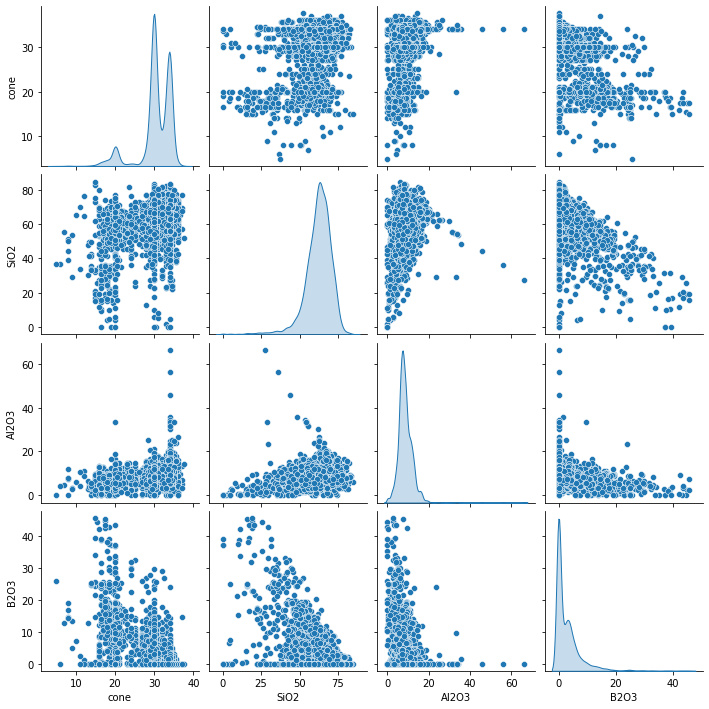

In [135]:
g = sns.pairplot(train_dataset[['cone', 'SiO2', 'Al2O3', 'B2O3']], vars=['cone', 'SiO2', 'Al2O3', 'B2O3'], diag_kind='kde')

Also look at the overall statistics, note how each feature covers a very different range:

In [136]:
train_dataset.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
cone,8191.0,30.307044,4.169534,5.0,30.0,30.0,33.5,37.5
SiO2,8191.0,62.007215,8.875657,0.0,58.1,63.1,67.6,84.8
Al2O3,8191.0,8.518203,3.352368,0.0,6.5,8.0,10.2,66.3
B2O3,8191.0,2.965535,4.701345,0.0,0.0,1.1,4.2,45.7
Li2O,8191.0,0.875595,3.070406,-6.2,0.0,0.0,0.0,70.3
K2O,8191.0,2.381138,2.072502,0.0,1.0,1.9,3.2,18.3
Na2O,8191.0,3.515944,2.981959,0.0,1.6,2.9,4.9,100.0
MgO,8191.0,2.836357,3.833379,0.0,0.1,1.1,4.6,55.8
CaO,8191.0,10.898230,6.084792,0.0,7.3,10.8,14.1,65.7
SrO,8191.0,0.532853,2.340943,0.0,0.0,0.0,0.0,34.4


### Split features from labels

Separate the target value, the "label", from the features. This label is the value that you will train the model to predict.

In [137]:
train_features = train_dataset.copy()
test_features = test_dataset.copy()

train_labels = train_features.pop('cone')
test_labels = test_features.pop('cone')

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [138]:
train_dataset.describe().transpose()[['mean', 'std']]

,mean,std
cone,30.307044,4.169534
SiO2,62.007215,8.875657
Al2O3,8.518203,3.352368
B2O3,2.965535,4.701345
Li2O,0.875595,3.070406
K2O,2.381138,2.072502
Na2O,3.515944,2.981959
MgO,2.836357,3.833379
CaO,10.898230,6.084792
SrO,0.532853,2.340943


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [139]:
normalizer = preprocessing.Normalization()

Then `.adapt()` it to the data:

In [140]:
normalizer.adapt(np.array(train_features))

This calculates the mean and variance, and stores them in the layer. 

In [141]:
print(normalizer.mean.numpy())

[62.007  8.518  2.966  0.876  2.381  3.516  2.836 10.898  0.533  0.627
  1.373  0.111  0.18   0.029  0.033  0.129  0.017  0.778  0.181  0.028
  0.365  0.002  0.951  0.326  0.239]


When the layer is called it returns the input data, with each feature independently normalized:

In [142]:
first = np.array(train_features[:1])

with np.printoptions(precision=2, suppress=True):
  print('First example:', first)
  print()
  print('Normalized:', normalizer(first).numpy())

First example: [[54.6  6.4  3.8  0.   0.2  3.5  7.9 12.1  0.   0.   0.   0.   0.   0.
   0.   0.   0.   0.7  0.   0.   0.   0.  10.7  0.   0. ]]

Normalized: [[-0.83 -0.63  0.18 -0.29 -1.05 -0.01  1.32  0.2  -0.23 -0.24 -0.37 -0.06
  -0.26 -0.13 -0.05 -0.12 -0.08 -0.05 -0.3  -0.1  -0.22 -0.02  4.11 -0.27
  -0.23]]


## Linear regression

Before building a DNN model, start with a linear regression.

### One Variable

Start with a single-variable linear regression, to predict `cone` from `SiO2`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

* Normalize the input `SiO2`.
* Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

First create the SiO2 `Normalization` layer:

In [143]:
SiO2 = np.array(train_features['SiO2'])

SiO2_normalizer = preprocessing.Normalization(input_shape=[1,])
SiO2_normalizer.adapt(SiO2)

Build the sequential model:

In [144]:
SiO2_model = tf.keras.Sequential([
    SiO2_normalizer,
    layers.Dense(units=1)
])

SiO2_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 2         
Total params: 5
Trainable params: 2
Non-trainable params: 3
_________________________________________________________________


This model will predict `cone` from `SiO2`.

Run the untrained model on the first 10 SiO2 values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [145]:
SiO2_model.predict(SiO2[:10])

array([[-0.334],
       [ 0.054],
       [ 0.324],
       [ 0.072],
       [ 0.549],
       [ 0.473],
       [-0.532],
       [ 0.315],
       [ 0.428],
       [ 0.266]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`).

In [146]:
SiO2_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

Once the training is configured, use `Model.fit()` to execute the training:

In [147]:
%%time
history = SiO2_model.fit(
    train_features['SiO2'], train_labels,
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 48.5 s, sys: 8.76 s, total: 57.3 s
Wall time: 28.9 s


Visualize the model's training progress using the stats stored in the `history` object.

In [148]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,val_loss,epoch
95,2.633641,2.722620,95
96,2.634695,2.726860,96
97,2.634884,2.741130,97
98,2.633565,2.708462,98
99,2.636328,2.735266,99


In [149]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.ylim([0, 10])
  plt.xlabel('Epoch')
  plt.ylabel('Error [cone]')
  plt.legend()
  plt.grid(True)

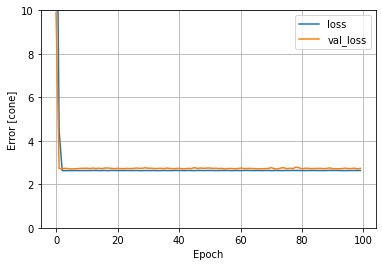

In [150]:
plot_loss(history)

Collect the results on the test set, for later:

In [151]:
test_results = {}

test_results['SiO2_model'] = SiO2_model.evaluate(
    test_features['SiO2'],
    test_labels, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [152]:
x = tf.linspace(0.0, 250, 251)
y = SiO2_model.predict(x)

In [153]:
def plot_SiO2(x, y):
  plt.scatter(train_features['SiO2'], train_labels, label='Data')
  plt.plot(x, y, color='k', label='Predictions')
  plt.xlabel('SiO2')
  plt.ylabel('cone')
  plt.legend()

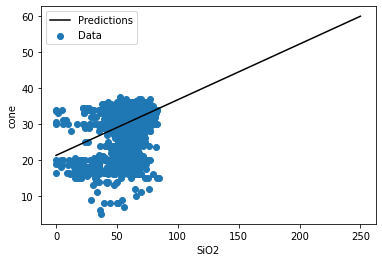

In [154]:
plot_SiO2(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time use the `Normalization` layer that was adapted to the whole dataset.

In [155]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [156]:
linear_model.predict(train_features[:10])

array([[ 0.88 ],
       [ 0.135],
       [-0.401],
       [-1.281],
       [ 1.461],
       [ 0.467],
       [ 0.905],
       [ 1.006],
       [-0.362],
       [ 1.163]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [157]:
linear_model.layers[1].kernel

<tf.Variable 'dense_20/kernel:0' shape=(25, 1) dtype=float32, numpy=
array([[-0.208],
       [ 0.34 ],
       [-0.248],
       [ 0.411],
       [-0.442],
       [-0.313],
       [-0.106],
       [-0.261],
       [ 0.029],
       [-0.465],
       [-0.157],
       [ 0.228],
       [-0.396],
       [-0.144],
       [-0.155],
       [-0.369],
       [-0.061],
       [ 0.308],
       [ 0.402],
       [ 0.055],
       [-0.155],
       [-0.147],
       [ 0.112],
       [-0.254],
       [-0.25 ]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `SiO2` model:

In [158]:
linear_model.compile(
    optimizer=tf.optimizers.Adam(learning_rate=0.1),
    loss='mean_absolute_error')

In [159]:
%%time
history = linear_model.fit(
    train_features, train_labels, 
    epochs=100,
    # suppress logging
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2)

CPU times: user 49 s, sys: 8.5 s, total: 57.5 s
Wall time: 29 s


Using all the inputs achieves a much lower training and validation error than the `SiO2` model: 

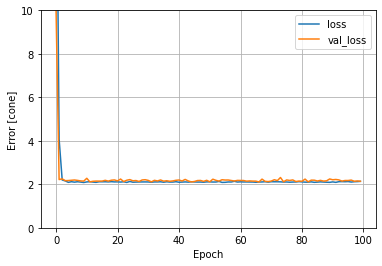

In [160]:
plot_loss(history)

Collect the results on the test set, for later:

In [161]:
test_results['linear_model'] = linear_model.evaluate(
    test_features, test_labels, verbose=0)

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

* The normalization layer.
* Two hidden, nonlinear, `Dense` layers using the `relu` nonlinearity.
* A linear single-output layer.

Both will use the same training procedure so the `compile` method is included in the `build_and_compile_model` function below.

In [162]:
def build_and_compile_model(norm):
  model = keras.Sequential([
      norm,
      layers.Dense(64, activation='relu'),
      layers.Dense(64, activation='relu'),
      layers.Dense(1)
  ])

  model.compile(loss='mean_absolute_error',
                optimizer=tf.keras.optimizers.Adam(0.001))
  return model

### One variable

Start with a DNN model for a single input: "SiO2"

In [163]:
dnn_SiO2_model = build_and_compile_model(SiO2_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [164]:
dnn_SiO2_model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_5 (Normalizati (None, 1)                 3         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                128       
_________________________________________________________________
dense_22 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_23 (Dense)             (None, 1)                 65        
Total params: 4,356
Trainable params: 4,353
Non-trainable params: 3
_________________________________________________________________


Train the model:

In [165]:
%%time
history = dnn_SiO2_model.fit(
    train_features['SiO2'], train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 53.1 s, sys: 8.83 s, total: 1min 1s
Wall time: 32.5 s


This model does slightly better than the linear SiO2 model.

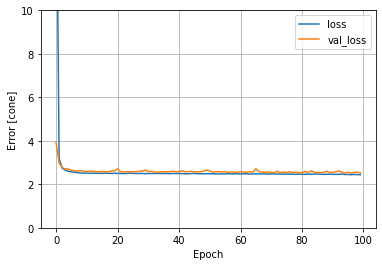

In [166]:
plot_loss(history)

If you plot the predictions as a function of `SiO2`, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:

In [167]:
x = tf.linspace(0.0, 250, 251)
y = dnn_SiO2_model.predict(x)

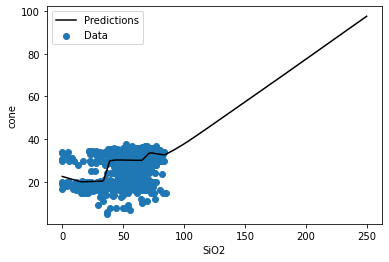

In [168]:
plot_SiO2(x, y)

Collect the results on the test set, for later:

In [169]:
test_results['dnn_SiO2_model'] = dnn_SiO2_model.evaluate(
    test_features['SiO2'], test_labels,
    verbose=0)

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [170]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
normalization_4 (Normalizati (None, 25)                51        
_________________________________________________________________
dense_24 (Dense)             (None, 64)                1664      
_________________________________________________________________
dense_25 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_26 (Dense)             (None, 1)                 65        
Total params: 5,940
Trainable params: 5,889
Non-trainable params: 51
_________________________________________________________________


In [171]:
%%time
history = dnn_model.fit(
    train_features, train_labels,
    validation_split=0.2,
    verbose=0, epochs=100)

CPU times: user 53.3 s, sys: 8.99 s, total: 1min 2s
Wall time: 32.7 s


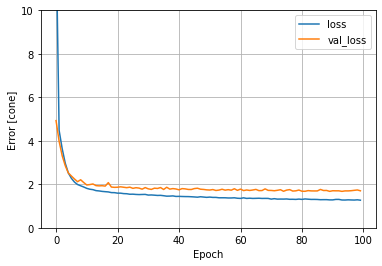

In [172]:
plot_loss(history)

Collect the results on the test set:

In [173]:
test_results['dnn_model'] = dnn_model.evaluate(test_features, test_labels, verbose=0)

## Performance

Now that all the models are trained check the test-set performance and see how they did:

In [174]:
pd.DataFrame(test_results, index=['Mean absolute error [cone]']).T

,Mean absolute error [cone]
SiO2_model,2.649857
linear_model,2.354662
dnn_SiO2_model,2.438880
dnn_model,1.807075


These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

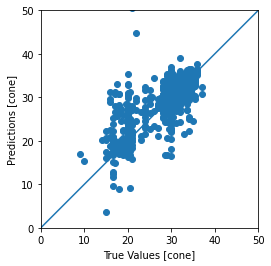

In [175]:
test_predictions = dnn_model.predict(test_features).flatten()

a = plt.axes(aspect='equal')
plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [cone]')
plt.ylabel('Predictions [cone]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)


It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

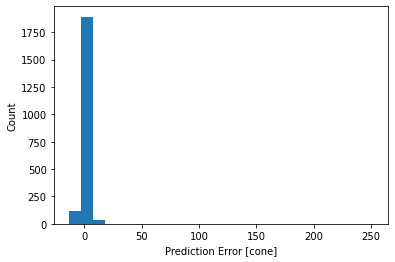

In [177]:
error = test_predictions - test_labels
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [cone]')
_ = plt.ylabel('Count')

If you're happy with the model save it for later use:

In [178]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


If you reload the model, it gives identical output:

In [179]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    test_features, test_labels, verbose=0)

In [180]:
pd.DataFrame(test_results, index=['Mean absolute error [cone]']).T

,Mean absolute error [cone]
SiO2_model,2.649857
linear_model,2.354662
dnn_SiO2_model,2.438880
dnn_model,1.807075
reloaded,1.807075


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

* [Mean Squared Error (MSE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanSquaredError) and [Mean Absolute Error (MAE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanAbsoluteError) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.
* Similarly, evaluation metrics used for regression differ from classification.
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* Overfitting is a common problem for DNN models, it wasn't a problem for this tutorial. See the [overfit and underfit](overfit_and_underfit.ipynb) tutorial for more help with this.
